# I. Supervised Learning - Classification

In [53]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import wandb 

In [55]:
run = wandb.init(
    project="test_project",
    config={"test_param": 123},
    settings=wandb.Settings(init_timeout=120)
)
run.log({"test_metric": 456})
run.finish()

KeyboardInterrupt: 

In [54]:
run = wandb.init(
    project="my_fashion_mnist_projectv2", 
    config={
    "learning_rate": 0.001,
    "epochs": 1,
    "momentum": 0.9
})

CommError: Run initialization has timed out after 90.0 sec. Please try increasing the timeout with the `init_timeout` setting: `wandb.init(settings=wandb.Settings(init_timeout=120))`.

In [45]:



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST("./data", train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")

print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


In [46]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512), nn.ReLU(), nn.Linear(512, 512), nn.ReLU(), nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork()

In [47]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [48]:
def trainloop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss:{loss:>7f} [{current:>5d}/{size:>5d}]")
            wandb.log({"loss": loss, "step": current})

In [49]:
def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    wandb.log({"accuracy": correct * 100, "avg_loss": test_loss})

In [51]:
epochs = 1
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    trainloop(training_loader, model, loss_fn, optimizer)
    evaluate(validation_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss:2.352812 [    0/60000]


Error: You must call wandb.init() before wandb.log()

# II. Unsupervised Learning - Dimensionality reduction

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

### ===========================================================================

In [ ]:
tensor_transform = transforms.ToTensor()

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tensor_transform)

loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [ ]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        # self.encoder = torch.nn.Sequential(
        #    torch.nn.Linear(28 * 28, 128),
        #    torch.nn.ReLU(),
        #    torch.nn.Linear(128, 64),
        #    torch.nn.ReLU(),
        #    torch.nn.Linear(64, 36),
        #    torch.nn.ReLU(),
        #    torch.nn.Linear(36, 18),
        #    torch.nn.ReLU(),
        #    torch.nn.Linear(18, 9)
        # )
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),  # Bottleneck layer
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        # self.decoder = torch.nn.Sequential(
        #    torch.nn.Linear(9, 18),
        #    torch.nn.ReLU(),
        #    torch.nn.Linear(18, 36),
        #    torch.nn.ReLU(),
        #    torch.nn.Linear(36, 64),
        #    torch.nn.ReLU(),
        #    torch.nn.Linear(64, 128),
        #    torch.nn.ReLU(),
        #    torch.nn.Linear(128, 28 * 28),
        #    torch.nn.Sigmoid()
        # )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),  # Output scaled to [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-8)

In [ ]:
epochs = 10
outputs = []
losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for image, _ in loader:
        # Reshape the image to (-1, 784)
        image = image.view(-1, 28 * 28)

        # Forward pass
        reconstructed = model(image)

        # Calculate the loss
        loss = loss_function(reconstructed, image)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the loss and output for analysis
        losses.append(loss.detach())  # Detach the loss tensor to avoid tracking history
    outputs.append((epoch, image.detach(), reconstructed.detach()))

print("Training complete.")

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Training complete.


In [ ]:
# losses_np = [loss.detach().numpy() for loss in losses]

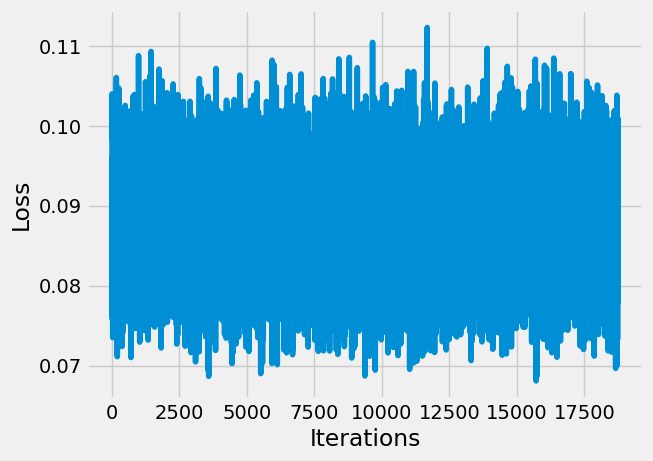

In [ ]:
# Defining the Plot Style
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.plot(losses)

In [ ]:
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.plot(losses[-100:])

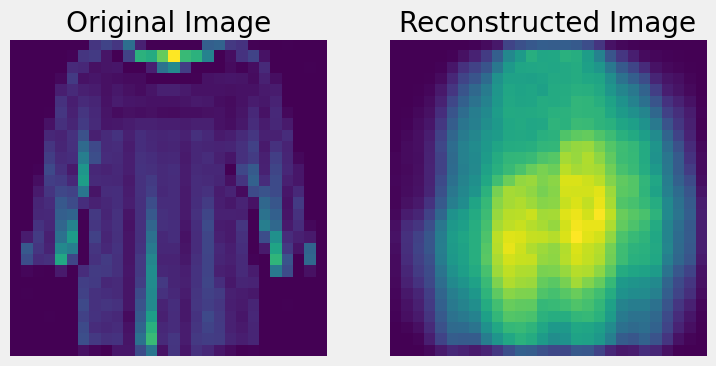

In [ ]:
_, first_input_batch, first_reconstructed_batch = outputs[0]

first_input_image = first_input_batch[0].view(28, 28).numpy()
first_reconstructed_image = first_reconstructed_batch[0].view(28, 28).detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Original image
axs[0].imshow(first_input_image)
axs[0].set_title("Original Image")
axs[0].axis("off")

# Reconstructed image
axs[1].imshow(first_reconstructed_image)
axs[1].set_title("Reconstructed Image")
axs[1].axis("off")

plt.show()

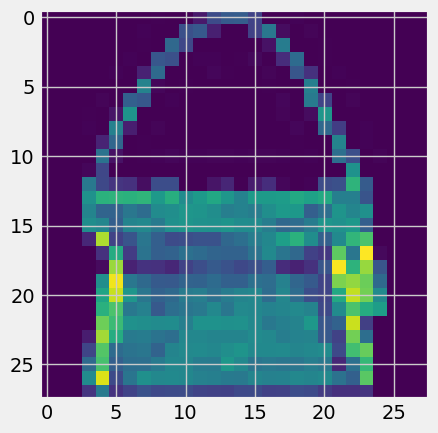

In [ ]:
for i, item in enumerate(image):
    # Reshape the array for plotting
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

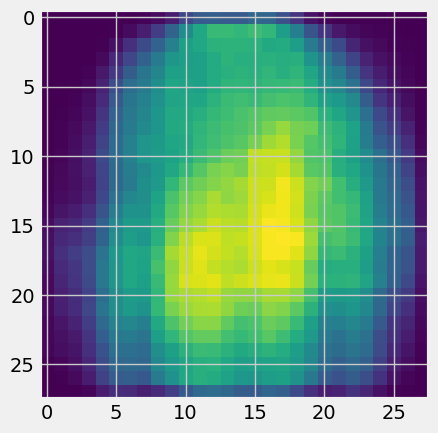

In [ ]:
for i, item in enumerate(reconstructed):
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0].detach().numpy())

### ===================================================================
# ten tutaj

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor_transform = transforms.ToTensor()

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tensor_transform)

loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [ ]:
class AE(torch.nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AE().to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8)

In [ ]:
epochs = 10
outputs = []
losses = []

for epoch in range(epochs):
    for image, _ in loader:
        # Flatten the image and move to device
        image = image.view(-1, 28 * 28).to(device)

        # Forward pass: compute the reconstructed image
        reconstructed = model(image)

        # Calculate loss
        loss = loss_function(reconstructed, image)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss for plotting
        losses.append(loss.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    outputs.append((epoch, image, reconstructed))

Epoch [1/10], Loss: 0.0329
Epoch [2/10], Loss: 0.0326
Epoch [3/10], Loss: 0.0324
Epoch [4/10], Loss: 0.0300
Epoch [5/10], Loss: 0.0268
Epoch [6/10], Loss: 0.0312
Epoch [7/10], Loss: 0.0379
Epoch [8/10], Loss: 0.0305
Epoch [9/10], Loss: 0.0338
Epoch [10/10], Loss: 0.0273


In [ ]:
# Defining the Plot Style
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.plot(losses)

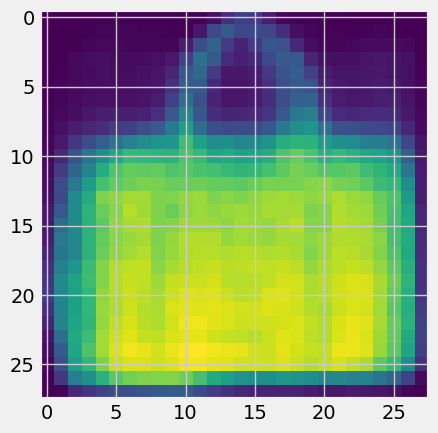

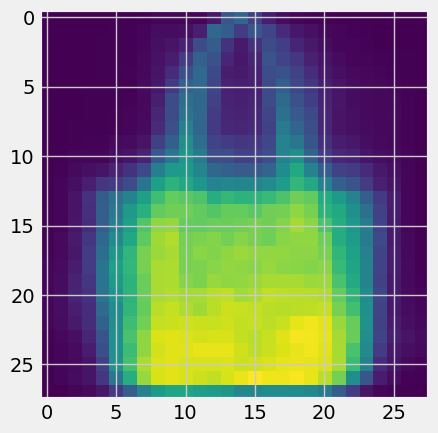

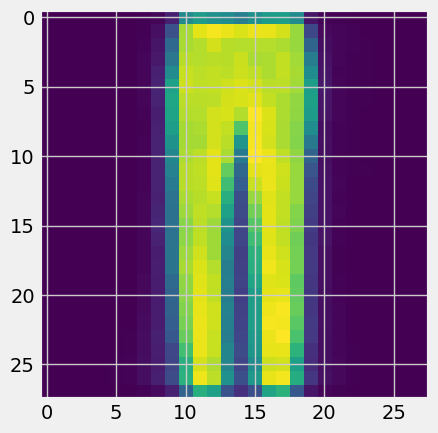

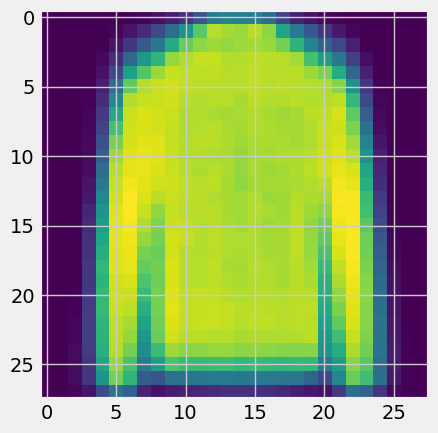

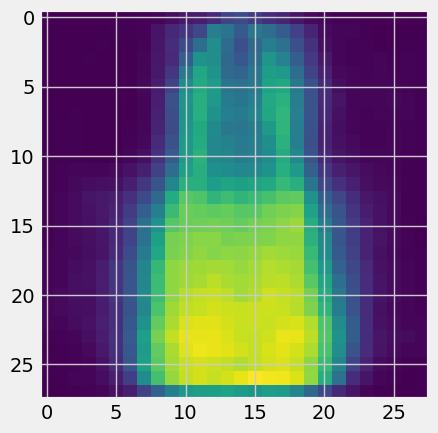

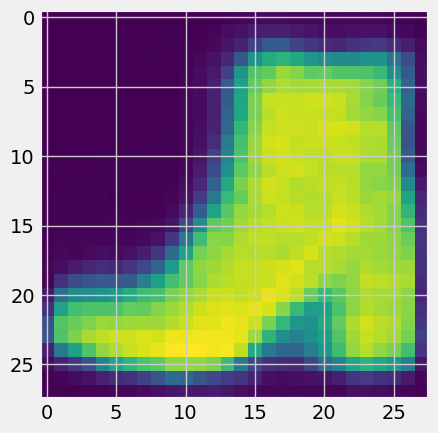

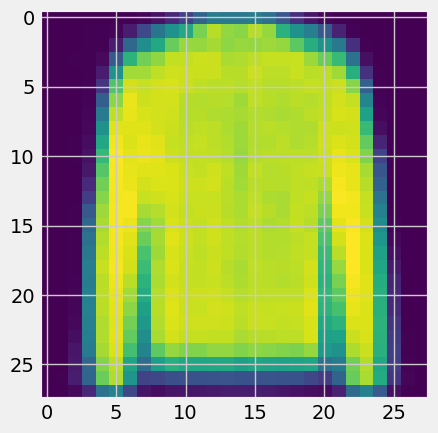

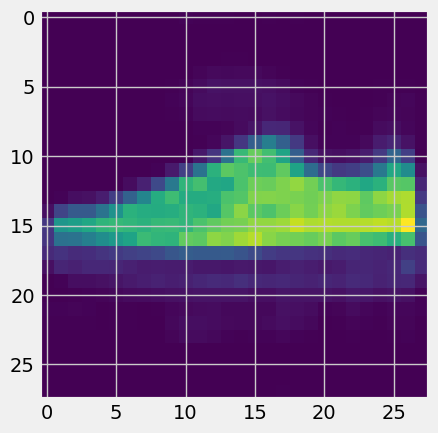

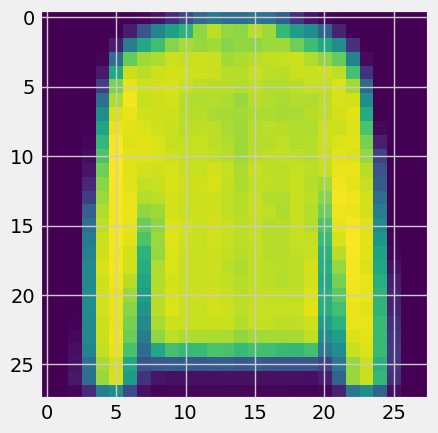

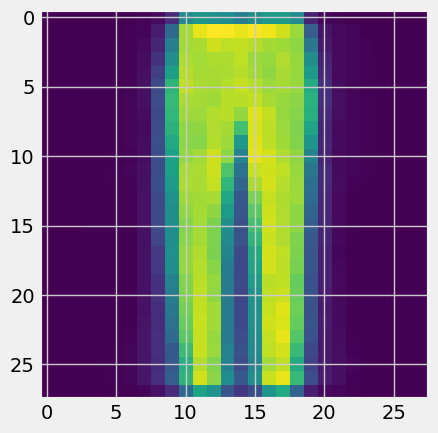

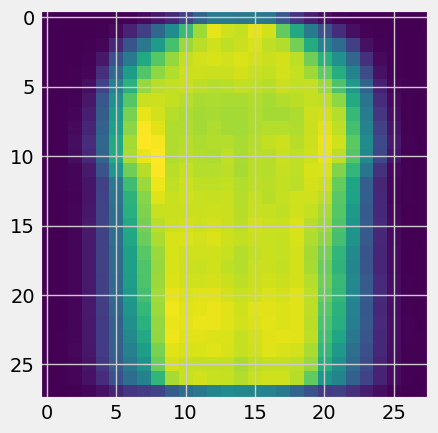

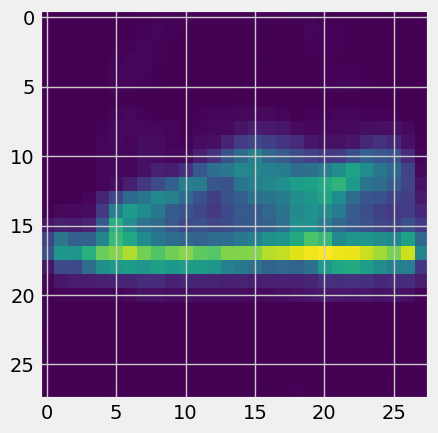

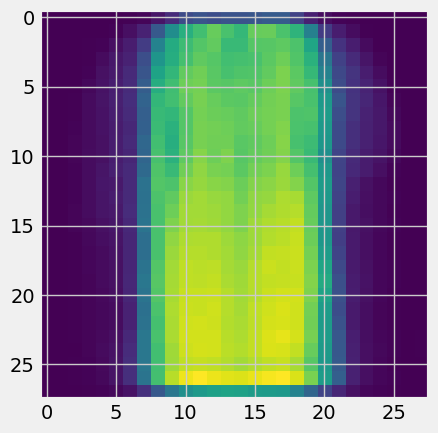

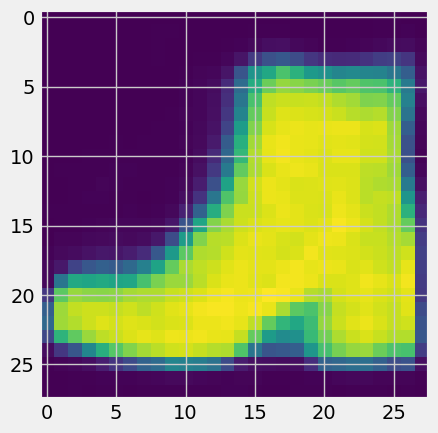

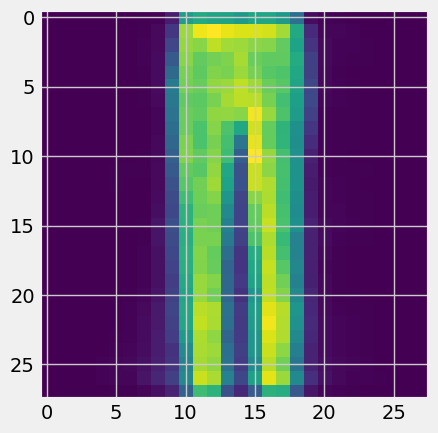

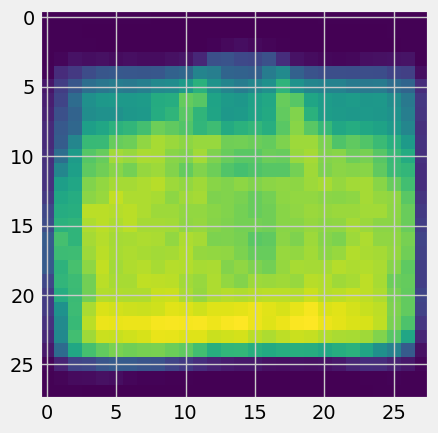

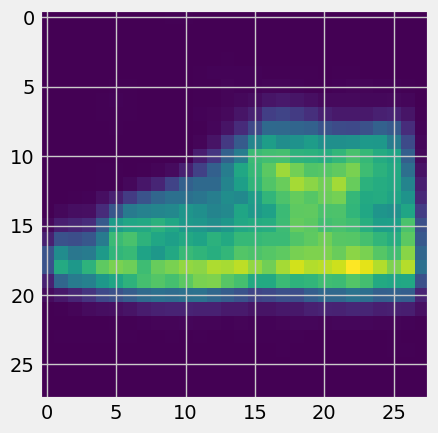

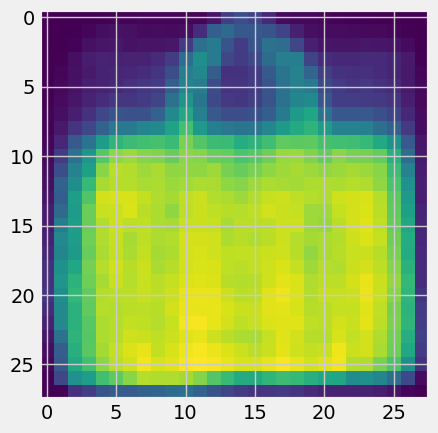

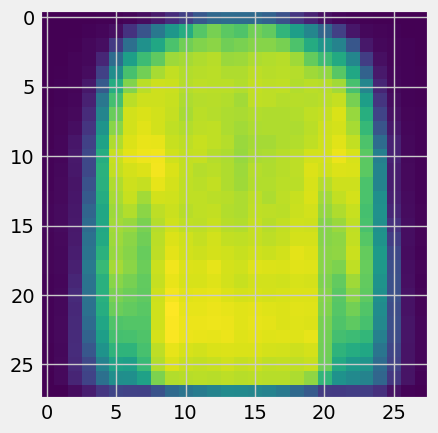

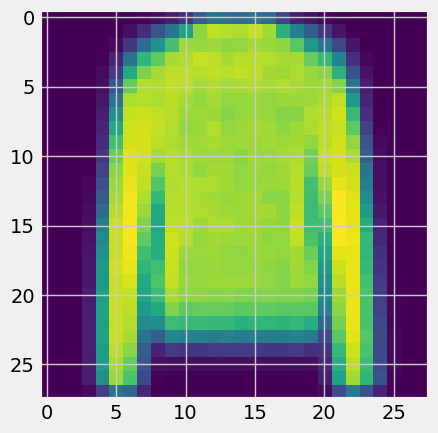

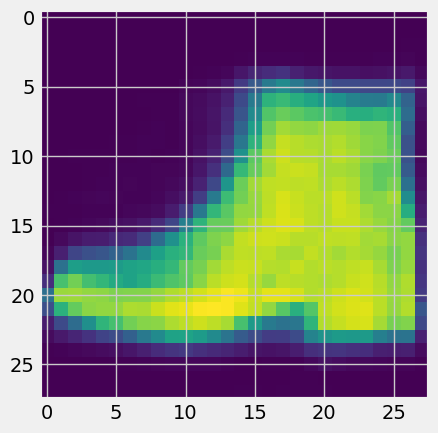

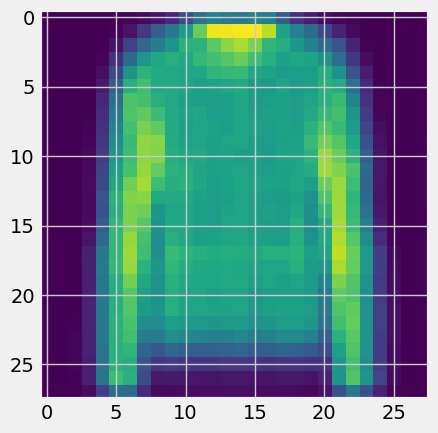

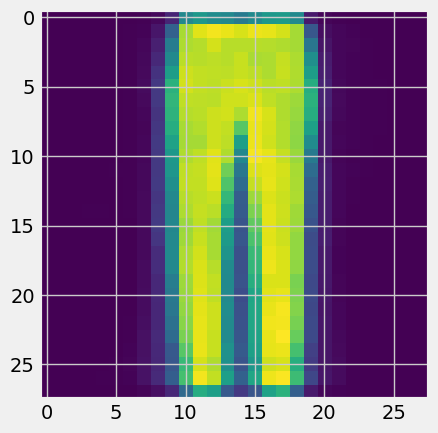

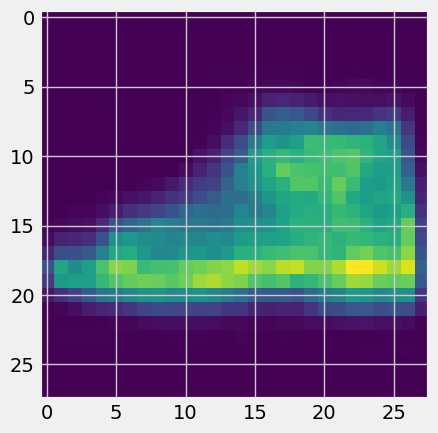

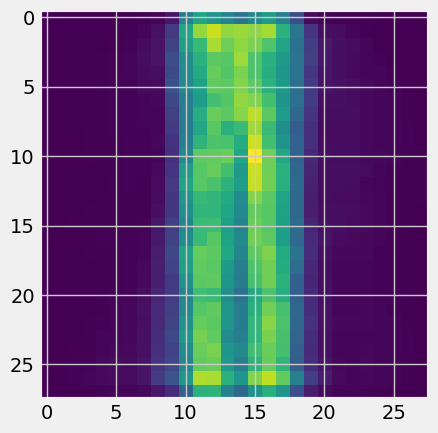

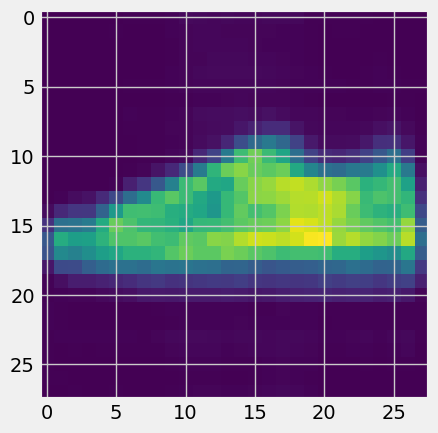

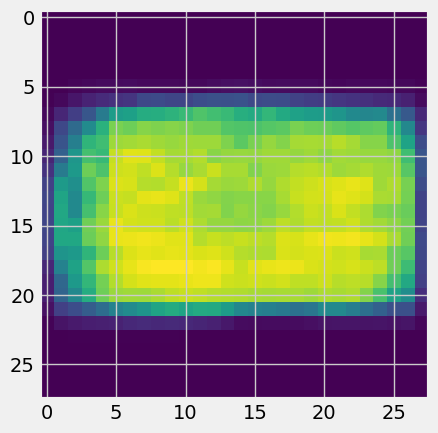

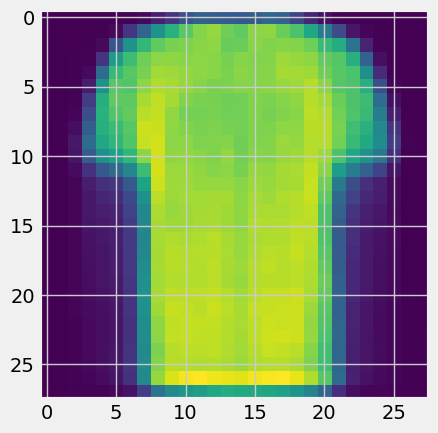

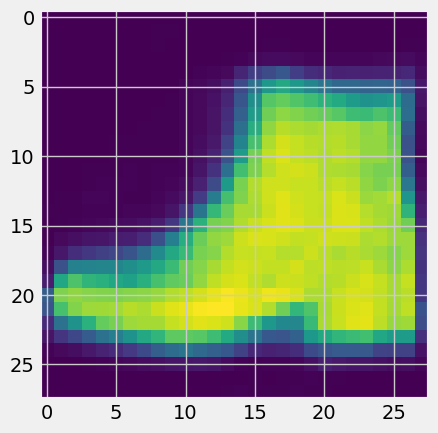

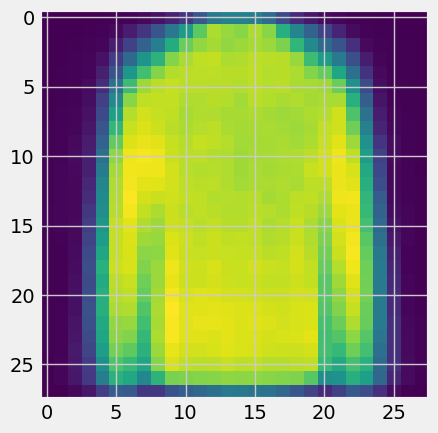

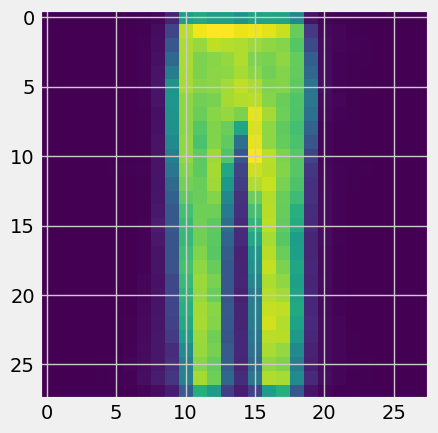

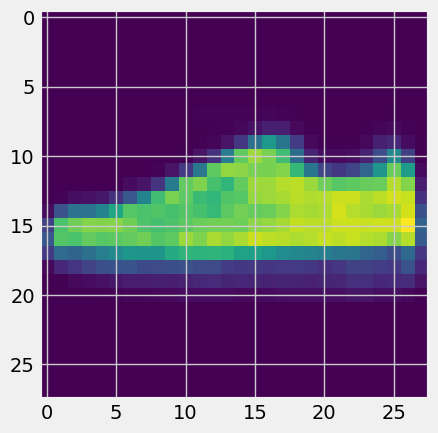

In [ ]:
for i, item in enumerate(reconstructed):
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0].detach().numpy())
    plt.show()

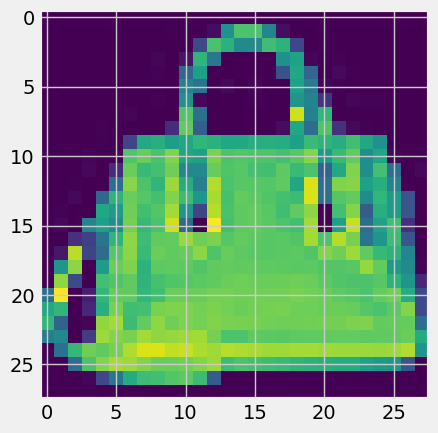

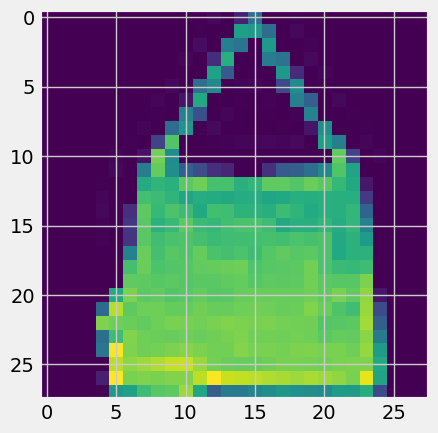

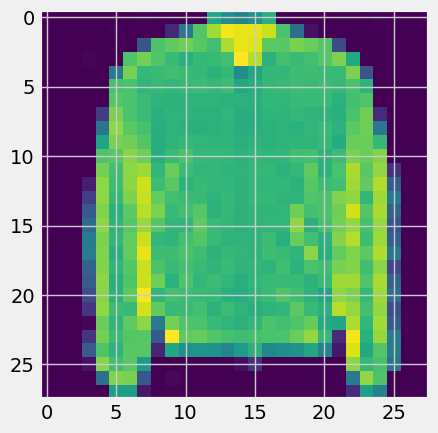

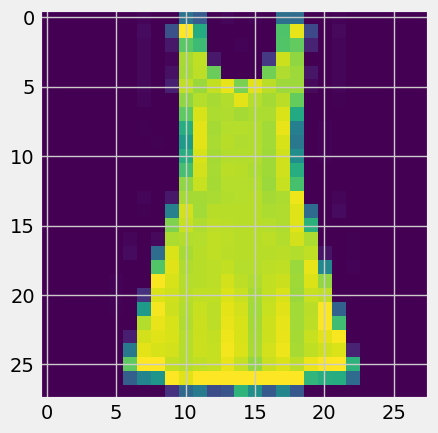

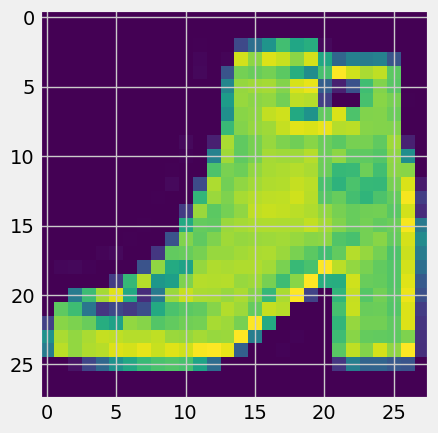

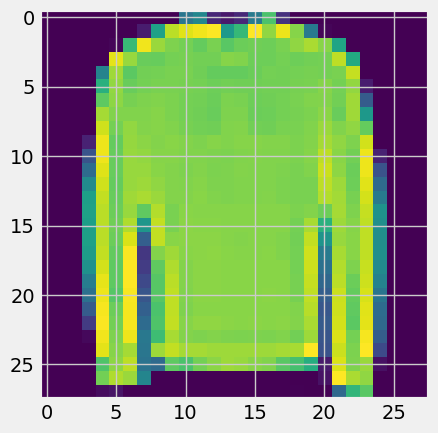

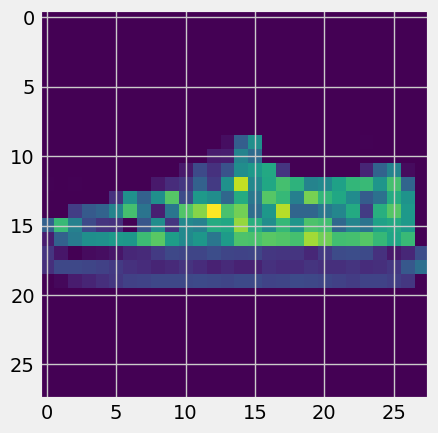

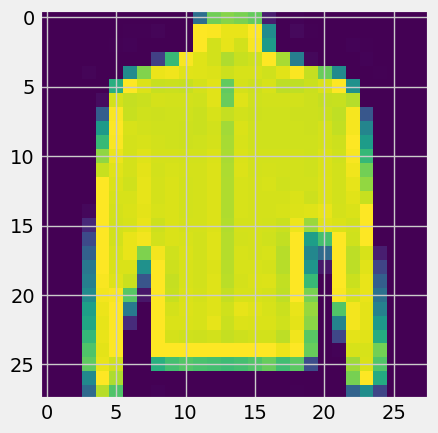

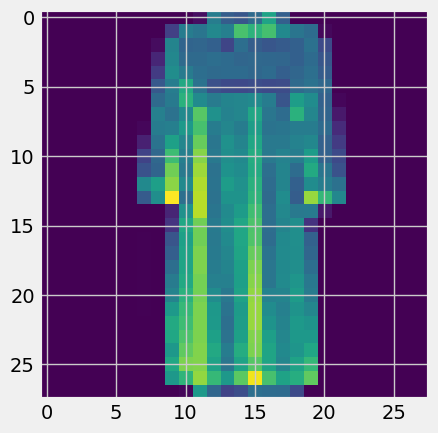

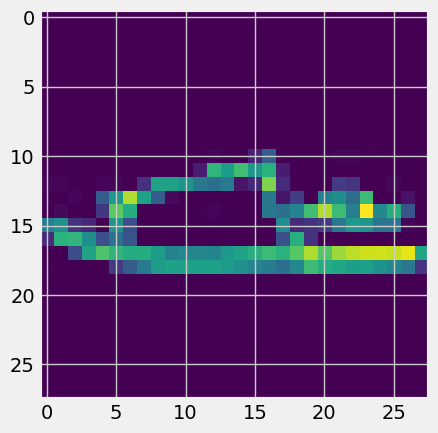

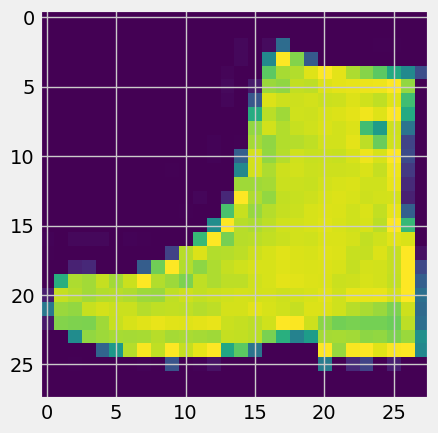

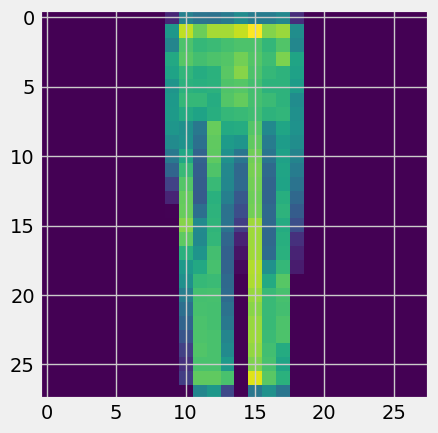

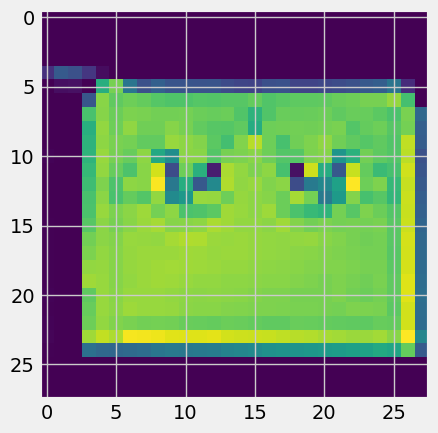

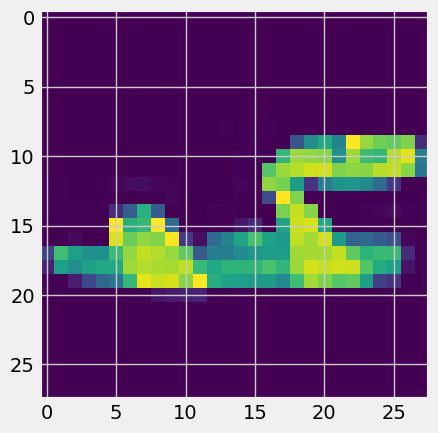

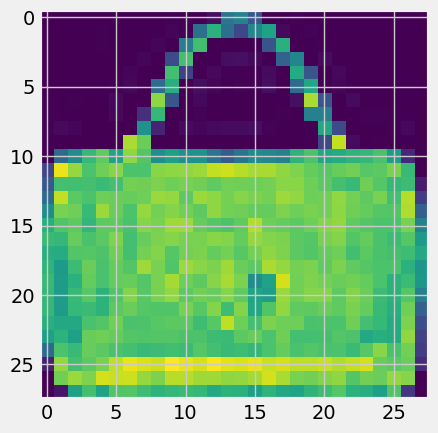

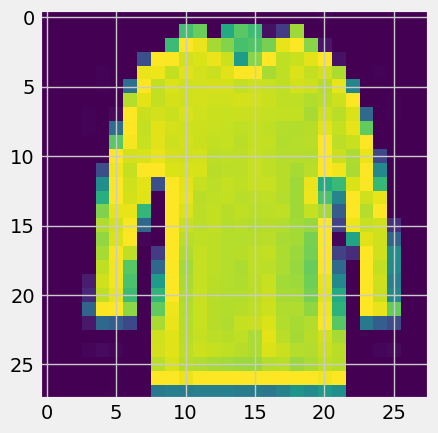

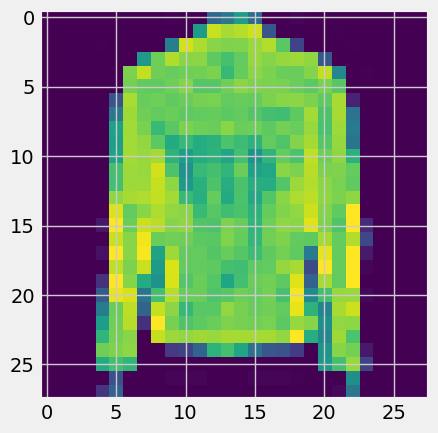

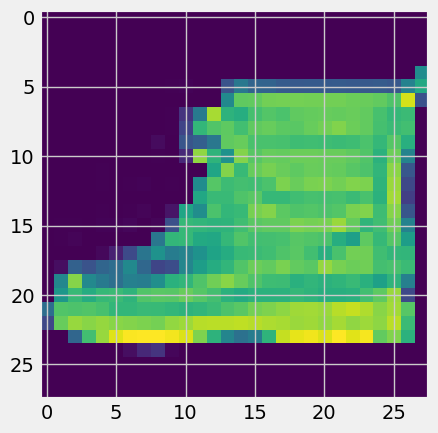

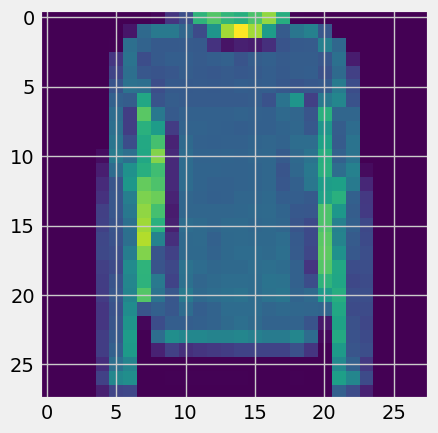

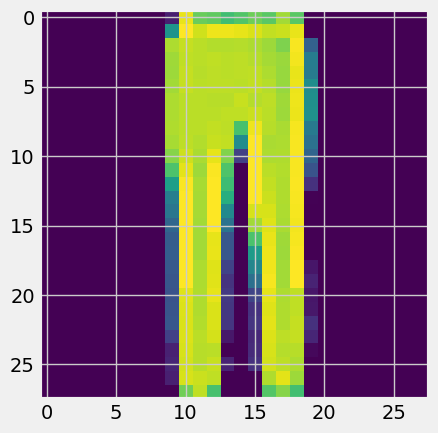

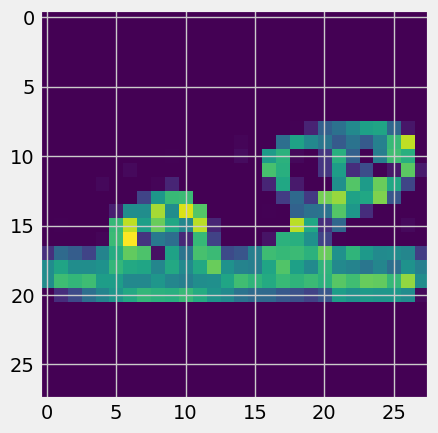

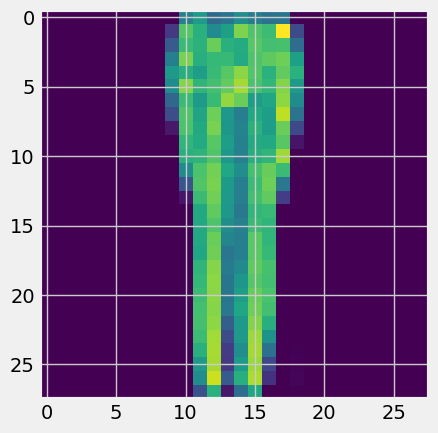

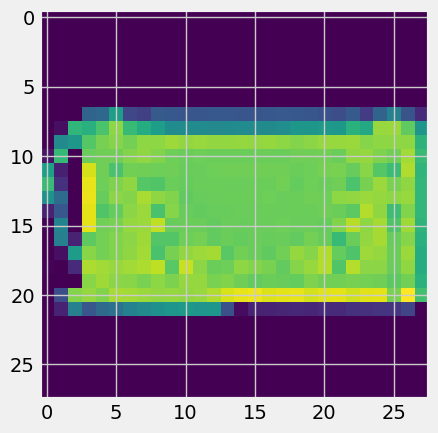

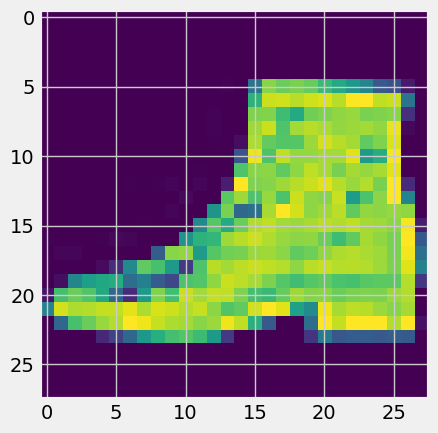

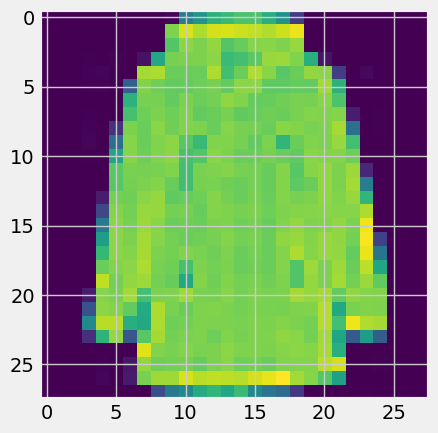

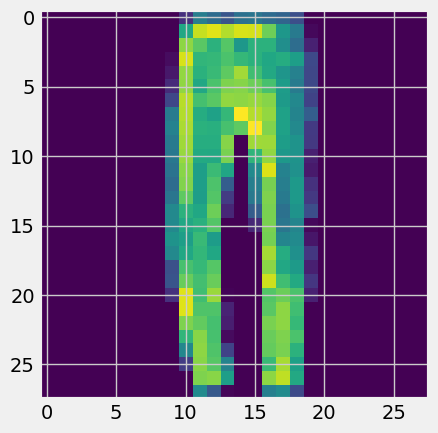

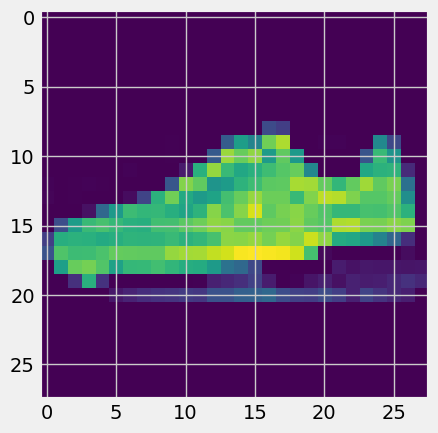

In [ ]:
for i, item in enumerate(image):

    # Reshape the array for plotting
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])
    plt.show()

 # III. Usage of pre-trained models - Speech Recognition

In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.5.0+cu121
2.5.0+cu121
cpu


In [ ]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

# SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 228MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
# IPython.display.Audio(SPEECH_FILE)

In [ ]:
filename = "343094__carmsie__think-about-it.wav"  # Replace with the path to your .wav file
waveform, sample_rate = torchaudio.load(filename)

# waveform, sample_rate = torchaudio.load(SPEECH_FILE)
# waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


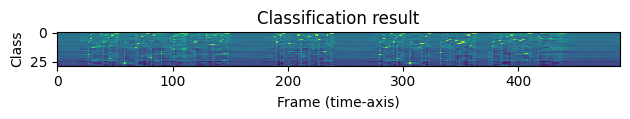

In [ ]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [ ]:
print(transcript)
IPython.display.Audio(filename)

YOU|HAVE|JUST|BEGON|HERING|THE|SENTENCE|YOU|HAVE|JUST|FINISHED|LISTENING|TOO|
